# DMQC Report: WMO 4902481

## Current status and metadata: 

- What kind of float?
- Active/inactive? When?
- Where is it?
- How many cycles has it completed?
- Is there in-air data?
- What mode is the data in right now?
- What is the gain with the data as is?

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt

from netCDF4 import Dataset

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 4902481 # insert WMO number here
fig_path = Path('../../../figures/') / f'{wmo}' # where to save figures
fig_path.mkdir(exist_ok=True)
bgc.io.get_argo(wmo, local_path=bgc.io.Path.ARGO_PATH, overwrite=False) # download the data to ensure you have up to date files
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA') # calculate gain, can change to ref='NCEP' if in-air data is available
print(np.nanmean(gains))
# in-air gain from SAGE-O2
SAGE_gain = 1.1124

\Users\GordonC\Documents\data\Argo\dac\meds\4902481\4902481_BRtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\4902481_Rtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\4902481_Sprof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\4902481_meta.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\4902481_prof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\4902481_tech.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\profiles\D4902481_001.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\profiles\D4902481_002.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\profiles\D4902481_003.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\profiles\D4902481_004.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\profiles\D4902481_005.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\profiles\D4902481_006.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902481\profiles\D4902481_007.nc
\Users\GordonC\Documents\data\Argo\dac\meds\49024

## Visual QC

- Visualize the float and reference surface saturations, as well as the profiles. 
- Observe if DOXY data is set to '3' as it should be or if it is '1' or '2'. 
- Try to note cycles or other identifying features of potentially problematic profiles.

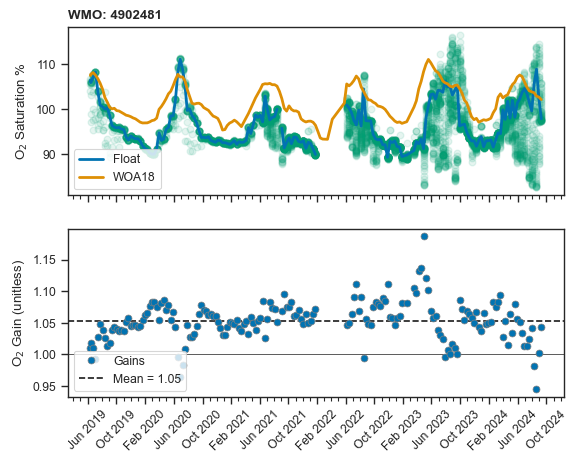

In [2]:
flt.clean()
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_initial.png', bbox_inches='tight', dpi=250)

Figure 1: Top panel: Float oxygen percent saturation (blue line) compared to WOA percent saturation (orange line), with DOXY audit flagged cycle percent saturation (green stars, if applicable) and raw float percent saturation (orange circles). Bottom panel: calculated gains (blue dots) and flagged gains from DOXY audit (orange stars).

Notes: [notes on what this figure tells you here] 

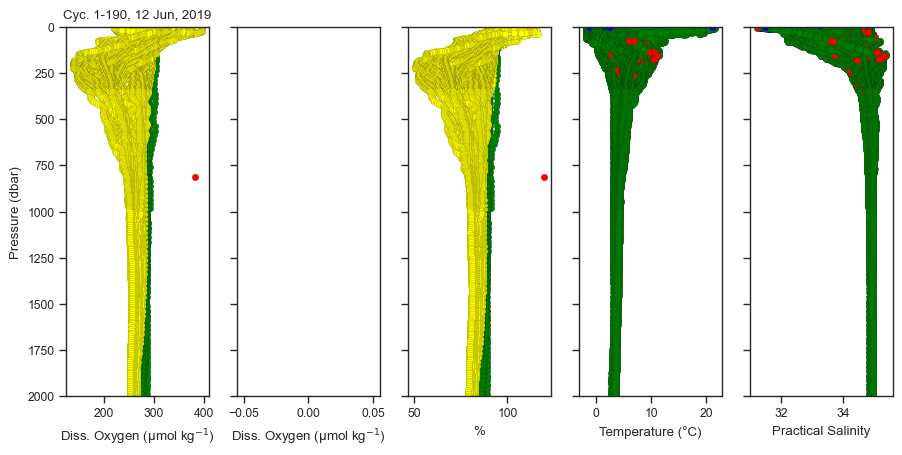

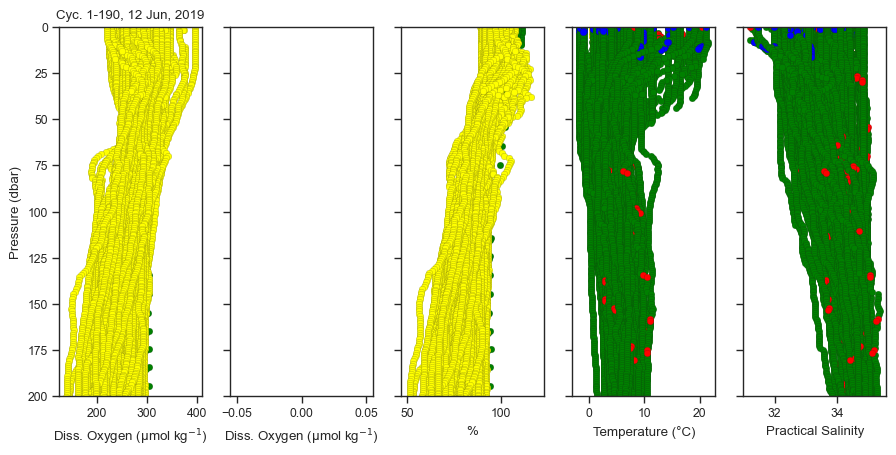

In [3]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))
g.fig.savefig(fig_path / 'qcprofiles_shallow.png', bbox_inches='tight', dpi=250)

Figures 2,3: Profiles coloured by QC flag (1-2, green, 3, yellow, 4, red) on difference depth scales.

Notes: [notes on what this figure tells you here] 

## Flag bad data, recalculate gain

- Using the plots above (and likely some more specific plots, made on a case-by-case basis), flag bad DOXY data as 4. 
- After flagging bad data, re-clean the data and re-calculate the gains.

Updating DOXY_QC on 0 levels
Updating DOXY_ADJUSTED_QC on 0 levels
Updating O2Sat on 0 levels

Calculating gains using WOA surface data and float O2 percent saturation...
1.0533151843957769
Updating DOXY_QC on 0 levels
Updating DOXY_ADJUSTED_QC on all levels
Updating DOXY_ADJUSTED_QC on 1 levels
Updating DOXY_ADJUSTED_QC on 0 levels
Updating DOXY_ADJUSTED_QC on 0 levels
Updating DOXY_ADJUSTED on all levels
Updating DOXY_ADJUSTED_QC on 42499 levels
Updating DOXY_ADJUSTED on 42499 levels
Updating DOXY_ADJUSTED_ERROR on 42499 levels


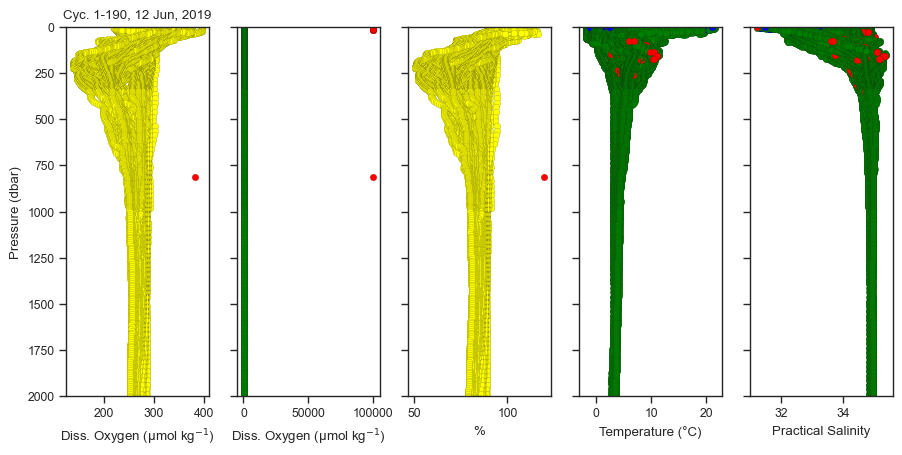

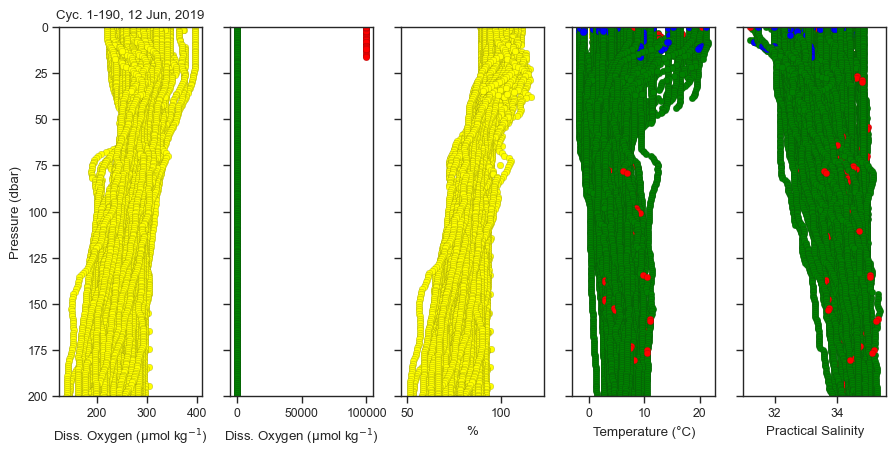

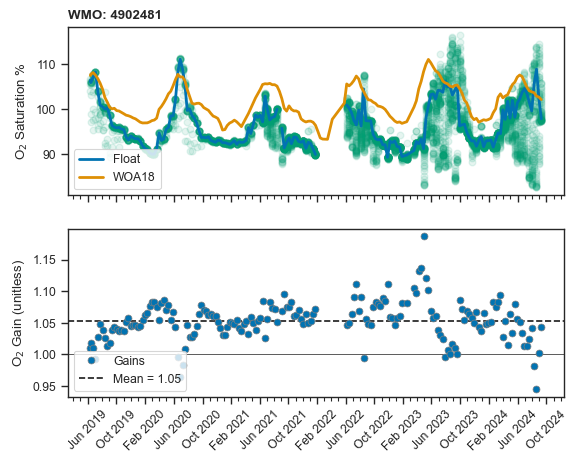

In [8]:
bad_oxygen = [] # index defining where the oxygen should be flagged as bad
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.set_fillvalue('O2Sat', where=flt.O2Sat == 4)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
print(np.nanmean(new_gains))

# make sure DOXY_QC is 3 instead of 0,1,2
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC.isin([0, 1, 2]))

# fill in DOXY_ADJUSTED_QC appropriately
flt.update_field('DOXY_ADJUSTED_QC', 1)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.DOXY_QC == 4)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)

# apply gain
flt.update_field('DOXY_ADJUSTED', SAGE_gain*flt.DOXY)

# make sure the data is FillValues where adjusted values are still bad
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.DOXY_ADJUSTED.isna())
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles_postqc.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))
g.fig.savefig(fig_path / 'qcprofiles_shallow_postqc.png', bbox_inches='tight', dpi=250)

flt.clean()
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_final.png', bbox_inches='tight', dpi=250)

Figure x: Repeated gain plot with bad data removed.

## Update Fields and Export

- DOXY should be 3 by default, but many old floats have 1 or 0. Though it will be redundant in some cases, make sure DOXY_QC is not good.
- Apply the gain to calculate DOXY_ADJUSTED. 
- Fill in DOXY_ADJUSTED_ERROR with an appropriate fixed value.
- Fill in DOXY_ADJUSTED_QC. 
- Make sure DOXY_ADJUSTED and DOXY_ADJUSTED_ERROR are `FillValue` wherever DOXY_ADJUSTED_QC is bad.
- Export the D-mode files. During export, HISTORY parameters will be filled as well as SCIENTIFIC_CALIB parameters using some default structures and user info set by calling `bgc.configure.configure()`.

In [5]:
# build comment
config = bgc.io.read_config()
comment = f'Gain calculated using in-air data in SAGE-O2. Adjustment applied by {config["operator"]} ({config["affiliation"]}, orcid: {config["orcid"]}).'
print(comment)

Gain calculated using in-air data in SAGE-O2. Adjustment applied by Christopher Gordon (Fisheries and Oceans Canada, orcid: 0000-0002-1756-422X).


In [6]:
# export the files - for R to D mode
# flt.export_files(data_mode='D', gain=SAGE_gain, comment=comment)



Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902481/profiles/BD4902481_001.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902481/profiles/BD4902481_001D.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902481/profiles/BD4902481_002.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902481/profiles/BD4902481_003.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902481/profiles/BD4902481_004.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902481/profiles/BD4902481_005.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902481/profiles/BD4902481_006.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902481/profiles/BD4902481_007.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902481/profiles/BD4902481_008.nc...done
Working o

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2, 530) and arg 1 with shape (0,).